In [ ]:
import numpy as np
from qrisp import QuantumVariable, rz, rzz, gphase
from qrisp.qaoa import QAOAProblem, RX_mixer
import pandas as pd
import matplotlib.pyplot as plt


Best 12-bit bitstring: 000001010001                                                  
Best cost: 179.796
Charge hours (0-23): [10, 11, 14, 15, 22, 23]
Discharge hours (0-23): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 18, 19, 20, 21]


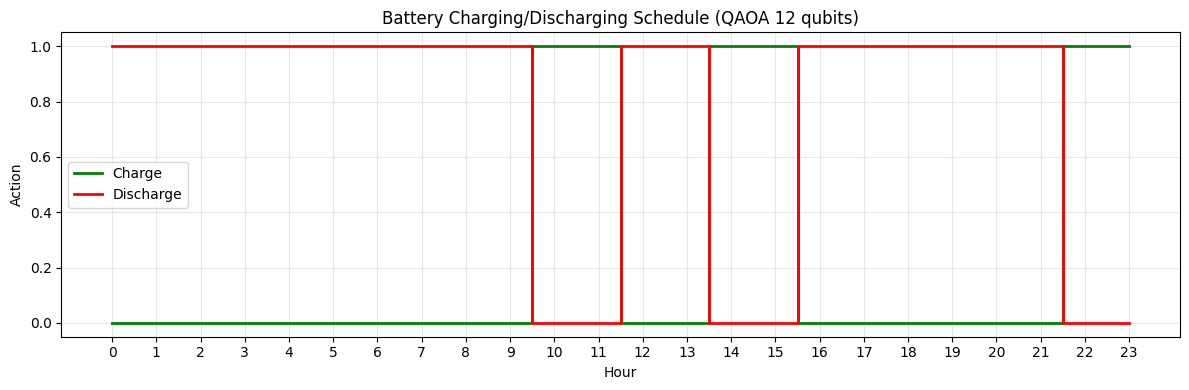

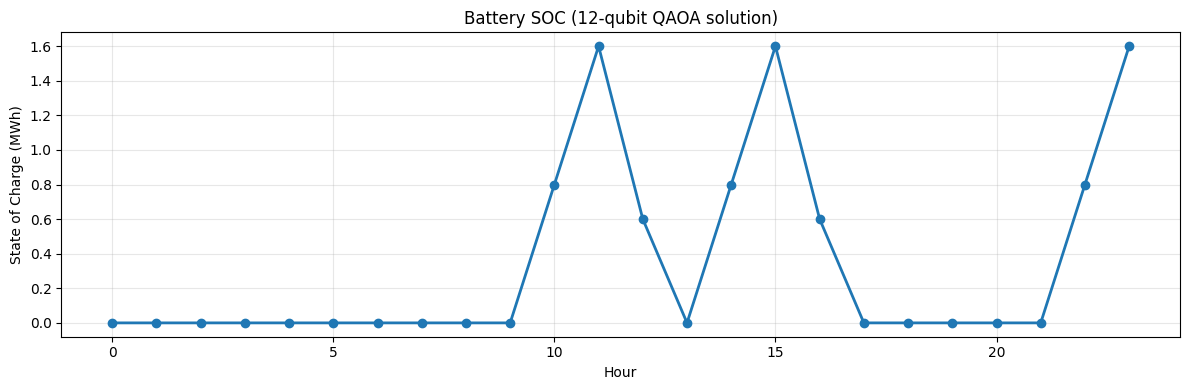

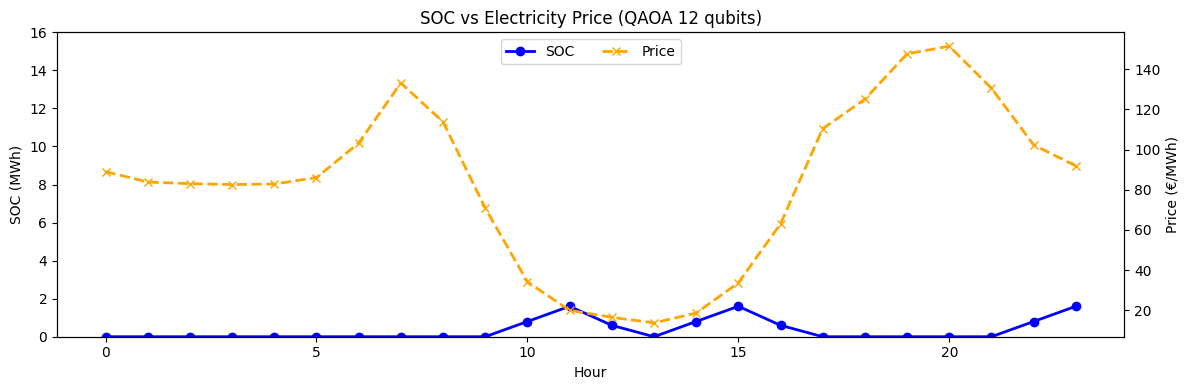

In [6]:
# ------------------------------
# 1) Load data
# ------------------------------
def load_data(input_csv="input_data.csv"):
    df = pd.read_csv(input_csv)
    T = list(df["hour"].astype(int))
    price = np.array([float(p) for p in df["price"]])
    scen_cols = [c for c in df.columns if c.startswith("scenario_")]
    S = len(scen_cols)
    wind = np.array(df[scen_cols].values)  # shape 24 x S
    return T, price, wind, S


# ------------------------------
# 2) Fold 24h into 12 qubits
# ------------------------------
def fold_24_to_12(price, wind):
    n = len(price)
    assert n == 24
    price_12 = [(price[2 * i] + price[2 * i + 1]) / 2 for i in range(12)]
    wind_12 = [(wind[2 * i, :] + wind[2 * i + 1, :]) / 2 for i in range(12)]
    wind_12 = np.array(wind_12)
    return np.array(price_12), wind_12


# ------------------------------
# 3) Build QUBO for 12 qubits
# ------------------------------
def build_qubo_12(price_12, wind_12, eta_c=0.8, lambda_SOC=50.0):
    n_qubits = len(price_12)
    Q = np.zeros((n_qubits, n_qubits))

    # Linear term: reward for charging (bit=1)
    for t in range(n_qubits):
        Q[t, t] = -eta_c * price_12[t]  # maximize revenue = minimize -profit

    # Quadratic term: SOC constraint (penalty for deviation)
    for i in range(n_qubits):
        for j in range(i + 1, n_qubits):
            Q[i, j] += lambda_SOC / 2.0
            Q[j, i] += lambda_SOC / 2.0
        Q[i, i] += lambda_SOC

    return Q


# ------------------------------
# 4) QAOA cost operator (Qrisp style)
# ------------------------------
def create_QUBO_cost_operator(Q):
    def QUBO_cost_operator(qv, gamma):
        gamma = gamma / np.sqrt(np.linalg.norm(Q) + 1e-12)
        gphase(-gamma / 4 * (np.sum(Q) + np.trace(Q)), qv[0])
        n = len(Q)
        for i in range(n):
            rz(-gamma / 2 * (np.sum(Q[i, :]) + np.sum(Q[:, i])), qv[i])
            for j in range(n):
                if i != j and Q[i, j] != 0:
                    rzz(gamma / 2 * Q[i, j], qv[i], qv[j])

    return QUBO_cost_operator


# ------------------------------
# 5) Classical cost function
# ------------------------------
def create_QUBO_cl_cost_function(Q):
    def cl_cost_function(counts):
        energy = 0.0
        for meas, w in counts.items():
            x = np.array(list(meas), dtype=int)
            cost = float(x.T @ Q @ x)
            energy += cost * float(w)
        return energy

    return cl_cost_function


# ------------------------------
# 6) Solve QAOA
# ------------------------------
def solve_qaoa_battery_12bit(
    input_csv="input_data.csv", depth=20, shots=5000, max_iter=200
):
    T, price, wind, S = load_data(input_csv)
    price_12, wind_12 = fold_24_to_12(price, wind)
    Q = build_qubo_12(price_12, wind_12)

    n_qubits = len(price_12)
    qarg = QuantumVariable(n_qubits)

    problem = QAOAProblem(
        cost_operator=create_QUBO_cost_operator(Q),
        mixer=RX_mixer,
        cl_cost_function=create_QUBO_cl_cost_function(Q),
    )

    res = problem.run(
        qarg,
        depth=depth,
        # backend="qasm",   # 使用 qasm 模拟器
        mes_kwargs={"shots": shots},
        max_iter=max_iter,
    )

    # 取概率最大 bitstring
    best_bitstring = max(res.items(), key=lambda kv: kv[1])[0]
    bits = np.array(list(best_bitstring), dtype=int)
    best_cost = float(bits.T @ Q @ bits)

    # 展开成24小时
    charge_hours = []
    discharge_hours = []
    for k, b in enumerate(bits):
        if b == 1:
            charge_hours.extend([2 * k, 2 * k + 1])
        else:
            discharge_hours.extend([2 * k, 2 * k + 1])

    return {
        "best_bitstring": best_bitstring,
        "bits": bits,
        "charge_hours": charge_hours,
        "discharge_hours": discharge_hours,
        "best_cost": best_cost,
        "Q": Q,
        "price_24": price,
    }


# ------------------------------
# 7) Visualization
# ------------------------------
def plot_qaoa_results(bits, charge_hours, discharge_hours, price_24):
    T = np.arange(24)
    charge_profile = np.zeros(24)
    discharge_profile = np.zeros(24)
    charge_profile[charge_hours] = 1
    discharge_profile[discharge_hours] = 1

    # 1) Charge/Discharge schedule
    plt.figure(figsize=(12, 4))
    plt.step(T, charge_profile, where="mid", label="Charge", linewidth=2, color="green")
    plt.step(
        T, discharge_profile, where="mid", label="Discharge", linewidth=2, color="red"
    )
    plt.xlabel("Hour")
    plt.ylabel("Action")
    plt.title("Battery Charging/Discharging Schedule (QAOA 12 qubits)")
    plt.xticks(T)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2) SOC cumulative
    soc = np.zeros(24)
    eta_c = 0.8
    for t in range(24):
        if charge_profile[t]:
            soc[t] = eta_c
        if t > 0:
            soc[t] += soc[t - 1]
        if discharge_profile[t]:
            soc[t] -= 1.0
        soc[t] = np.clip(soc[t], 0, 16)

    plt.figure(figsize=(12, 4))
    plt.plot(T, soc, marker="o", linewidth=2, label="SOC")
    plt.xlabel("Hour")
    plt.ylabel("State of Charge (MWh)")
    plt.title("Battery SOC (12-qubit QAOA solution)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 3) SOC vs Price
    fig, ax1 = plt.subplots(figsize=(12, 4))
    ax1.plot(T, soc, marker="o", linewidth=2, label="SOC", color="blue")
    ax1.set_xlabel("Hour")
    ax1.set_ylabel("SOC (MWh)")
    ax1.set_ylim(0, 16)

    ax2 = ax1.twinx()
    ax2.plot(
        T,
        price_24,
        marker="x",
        linestyle="--",
        color="orange",
        linewidth=2,
        label="Price",
    )
    ax2.set_ylabel("Price (€/MWh)")

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper center", ncol=2)
    plt.title("SOC vs Electricity Price (QAOA 12 qubits)")
    plt.tight_layout()
    plt.show()


# ------------------------------
# 8) Main
# ------------------------------
if __name__ == "__main__":
    out = solve_qaoa_battery_12bit("input_data.csv", depth=10, shots=5000, max_iter=100)
    print("Best 12-bit bitstring:", out["best_bitstring"])
    print("Best cost:", out["best_cost"])
    print("Charge hours (0-23):", sorted(out["charge_hours"]))
    print("Discharge hours (0-23):", sorted(out["discharge_hours"]))

    plot_qaoa_results(
        out["bits"], out["charge_hours"], out["discharge_hours"], out["price_24"]
    )
